<a href="https://colab.research.google.com/github/igordantasgf/analise_dados_microambientais/blob/main/compara%C3%A7%C3%A3o_modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dados do modelo WRF

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import datetime
from sys import exit
import math

labmim = pd.read_csv('/content/drive/MyDrive/Bolsa - Edson/plataforma/novos/labmim_completo_2016_2023_younes.dat',sep=';')
labmim.index = pd.to_datetime(labmim['year month day hour'.split()])

sw_dir = []
for dw, dif in zip(labmim['Sw_dw'],labmim['Sw_dif']):
    if not np.isnan(dw) and not np.isnan(dif) and dw-dif > 0:
        sw_dir.append(dw-dif)
    else:
        sw_dir.append(np.nan)

# filtro sw_dif errado
labmim[labmim['Sw_dif']>600] = np.nan

def plotar(banco):
  #panorama completo
  #banco['oc_topo'].plot()
  #banco['Sw_dw'].plot()
  #banco['Sw_dif'].plot()

  #plt.ylabel('Radiação (W/m²)')
  #plt.legend()
  #plt.savefig('rad-panorama.png',bbox_inches='tight')
  plt.show()
  plt.close()
  print("Valores NaN:")
  print('Sw_dw',banco["Sw_dw"].isna().sum())
  print('Sw_dif',banco["Sw_dif"].isna().sum())
  print('oc_topo',banco["oc_topo"].isna().sum())

This code below creates a function called zero_or_nan_values that takes in two parameters: a DataFrame and a column name. The function creates a new column called 'date' that combines the 'year', 'month', and 'day' columns into a single date format. It then groups the Data Frame by the 'date' column, iterates through each group (i.e. each day), and counts the number of non-zero and non-NaN values in the column specified in the parameter. If the count is less than 8, it sets all values in the column for that day to NaN. The function returns the modified DataFrame.

-  Corrigir:
  
  

- Feitos:\
  Descartar dias com chuva \
  Descartar dias com menos de 8 dados válidos\
  Descartar dados noturnos (7h - 18h)

In [3]:
def zero_or_nan_values(df, column):
    # Create a new column 'date' that combines the year, month, and day columns
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

    # Group the Data Frame by the 'date' column
    grouped = df.groupby('date')

    # Iterate through each group (i.e. each day)
    for name, group in grouped:
        # Count the number of non-zero and non-NaN values in the 'Sw_dw' column
        count = group[column].count()
        # If the count is less than 8
        if count < 8:
            # Set all values in the 'Sw_dw' column for that day to NaN
            df.loc[df['date'] == name, column] = pd.np.nan
    return df

zero_or_nan_values(labmim, 'oc_topo')
zero_or_nan_values(labmim, 'Sw_dw')
zero_or_nan_values(labmim, 'Sw_dif')

def transform_to_nan(df, parameter):
    # Create a mask to identify the rows where the hour is not between 8-18
    mask = (df['hour'] < 8) | (df['hour'] > 18)

    # Replace the Sw_dw values with NaN where the mask is True
    df.loc[mask, parameter] = np.nan

    # Return the transformed data frame
    return df

transform_to_nan(labmim, 'oc_topo')
transform_to_nan(labmim, 'Sw_dw')
transform_to_nan(labmim, 'Sw_dif')

def remove_rain(df, parameter):
    # Group by year, month and day
    grouped = df.groupby(['year', 'month', 'day'])

    # Iterate over the groups
    for name, group in grouped:
        # Check if the precip value is different from zero or NaN
        if group['precip'].notna().any() and group['precip'].sum() > 0:
            # Set the Sw_dw values to NaN
            df.loc[group.index, parameter] = np.nan

    # Return the modified data frame
    return df

#remove_rain(labmim, 'oc_topo')
#remove_rain(labmim, 'Sw_dw')
#remove_rain(labmim, 'Sw_dif')

<ipython-input-3-0f379b7e334b>:15: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df.loc[df['date'] == name, column] = pd.np.nan
<ipython-input-3-0f379b7e334b>:15: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df.loc[df['date'] == name, column] = pd.np.nan


## As comparações entre uma base de dados obtida em laboratório e uma base de dados modelada podem incluir:

- Comparação de valores médios: Verificar se os valores médios obtidos a partir de dados experimentais e dados modelados são similares.

- Comparação de distribuições: Verificar se a distribuição de valores obtidos a partir de dados experimentais e dados modelados é semelhante.

- Comparação de tendências: Verificar se as tendências ao longo do tempo nos dados experimentais e modelados são similares.

- Comparação de desvios padrão: Verificar se os desvios padrão dos dados experimentais e modelados são semelhantes.

- Comparação de correlação: Verificar se a correlação entre as variáveis ​​dos dados experimentais e modelados é similar.

- Comparação de outliers: Verificar se há outliers semelhantes nos dados experimentais e modelados.

- Verificação de hipóteses: Verificar se as hipóteses que foram feitas sobre os dados experimentais e modelados são verdadeiras.

Essas comparações podem ser realizadas usando diferentes métodos estatísticos, como análise de variância (ANOVA), testes t, regressão linear, entre outros. O objetivo final é avaliar a precisão e a confiabilidade do modelo e identificar possíveis ajustes necessários.

* Importando dados e colunas

In [4]:
# Dados do modelo WRF
series = pd.read_csv('/content/drive/MyDrive/Bolsa - Edson/estudos/código_paper_bruno/series_operacional', sep=',')
series.index = pd.to_datetime(series['year month day hour'.split()])

#series.index
#series.columns

#labmim.index
#labmim.columns

inicio = max(series.index[0], labmim.index[0])
fim = min(series.index[-1], labmim.index[-1])

# Dados obtidos no labmim

series = series.dropna(subset=['Swdf','Swdw'])
series['Swdf'].replace(0, float('NaN'), inplace=True)
series['Swdw'].replace(0, float('NaN'), inplace=True)
labmim = labmim.dropna(subset=['Sw_dif','Sw_dw'])
labmim['Sw_dif'].replace(0, float('NaN'), inplace=True)
labmim['Sw_dw'].replace(0, float('NaN'), inplace=True)

labmim = labmim[str(inicio):str(fim)]
series = series[str(inicio):str(fim)]

meses = sorted(list(set(labmim['month'])))

<ipython-input-4-565f8b91330c>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labmim['Sw_dif'].replace(0, float('NaN'), inplace=True)
<ipython-input-4-565f8b91330c>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labmim['Sw_dw'].replace(0, float('NaN'), inplace=True)


## Comparação de distribuição dos dados

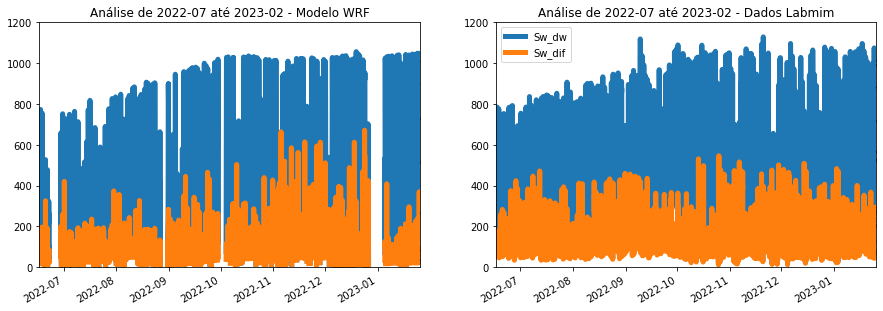

In [ ]:
#plotting
fig, ax = plt.subplots(1,2,figsize=(15, 5))

ax[0].set_title("Análise de 2022-07 até 2023-02 - Modelo WRF")
ax[0].plot_date(series.index, series['Swdw'], ls='-', lw=5, markersize=1, label='Sw_dw')
ax[0].plot_date(series.index, series['Swdf'], ls='-', lw=5, markersize=1, label='Sw_dif')
plt.legend()
fig.autofmt_xdate()
plt.ylim(0,1200)
ax[0].set_xlim([inicio,fim])
ax[0].set_ylim(0,1200)

ax[1].set_title("Análise de 2022-07 até 2023-02 - Dados Labmim")
ax[1].plot_date(labmim.index, labmim['Sw_dw'], ls='-', lw=5, markersize=1, label='Sw_dw')
ax[1].plot_date(labmim.index, labmim['Sw_dif'], ls='-', lw=5, markersize=1, label='Sw_dif')
plt.legend()
fig.autofmt_xdate()
plt.ylim(0,1200)
ax[1].set_xlim([inicio,fim])
ax[1].set_ylim(0,1200)

plt.show()

**Observação:**
- É necessário filtrar dados com erro, como o dado acima de 1200 no gráfico a direita



## Comparação de valores médios

(0.0, 760.0)

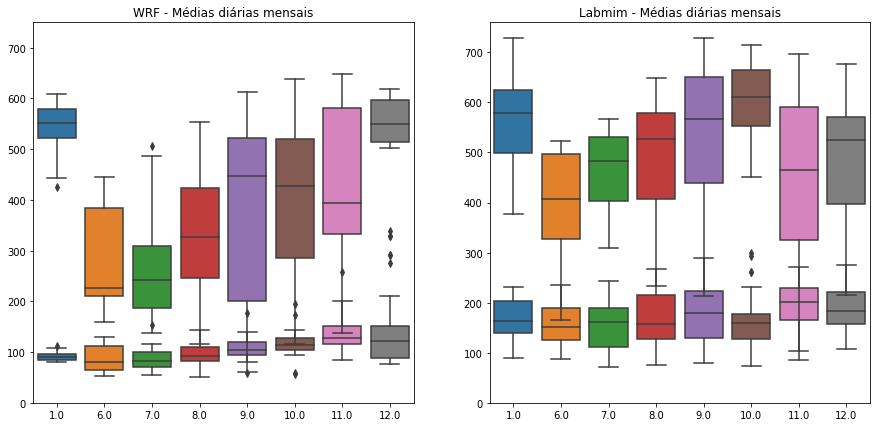

In [ ]:
def boxplot(dados,parametro):
  grouped = pd.DataFrame(dados.groupby('year month day'.split()).agg('mean'))
  grouped = pd.DataFrame(grouped.groupby('month'))
  lista = []
  for i in grouped[1]:
    lista.append(i[parametro])
  return lista

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
sns.boxplot(data=boxplot(series,'Swdw'),  orient='v' , ax=ax[0])
sns.boxplot(data=boxplot(series,'Swdf'),  orient='v' , ax=ax[0])
ax[0].set_xticklabels(meses)
ax[0].set_title("WRF - Médias diárias mensais")
ax[0].set_ylim(0,750)

sns.boxplot(data=boxplot(labmim,'Sw_dw'),  orient='v' , ax=ax[1])
sns.boxplot(data=boxplot(labmim,'Sw_dif'),  orient='v' , ax=ax[1])
ax[1].set_xticklabels(meses)
ax[1].set_title("Labmim - Médias diárias mensais")
ax[1].set_ylim(0,760)

## Modelo de regressão linear
- Dados WRF x LabMiM

In [20]:
labmim1 = labmim
series1 = series
# Set the index of both data frames to the columns year, month, day, and hour
labmim1 = labmim.set_index(['year', 'month', 'day', 'hour'])
series1 = series.set_index(['year', 'month', 'day', 'hour'])

# Merge the two data frames based on their index values
merged = labmim.merge(series, how='outer', left_index=True, right_index=True)

merged_hour = merged.sort_values('hour_x')
maximo = max(max(merged_hour['Sw_dw']), max(merged_hour['Swdw']))

#KT Colors
def color_func(row):
    sw_ratio = row['Sw_dw'] / row['oc_topo']
    if sw_ratio < 0.35:
        return 'Cloudy Sky'
    elif sw_ratio < 0.55:
        return 'Partially Cloudy Pred. Difuse'
    elif sw_ratio < 0.65:
        return 'Partially Cloudy Pred. Direct'
    else:
        return 'Clear Sky'

# Apply the function to create a new 'color' column in the data frame
merged_hour['Sky_condition'] = merged_hour.apply(color_func, axis=1)

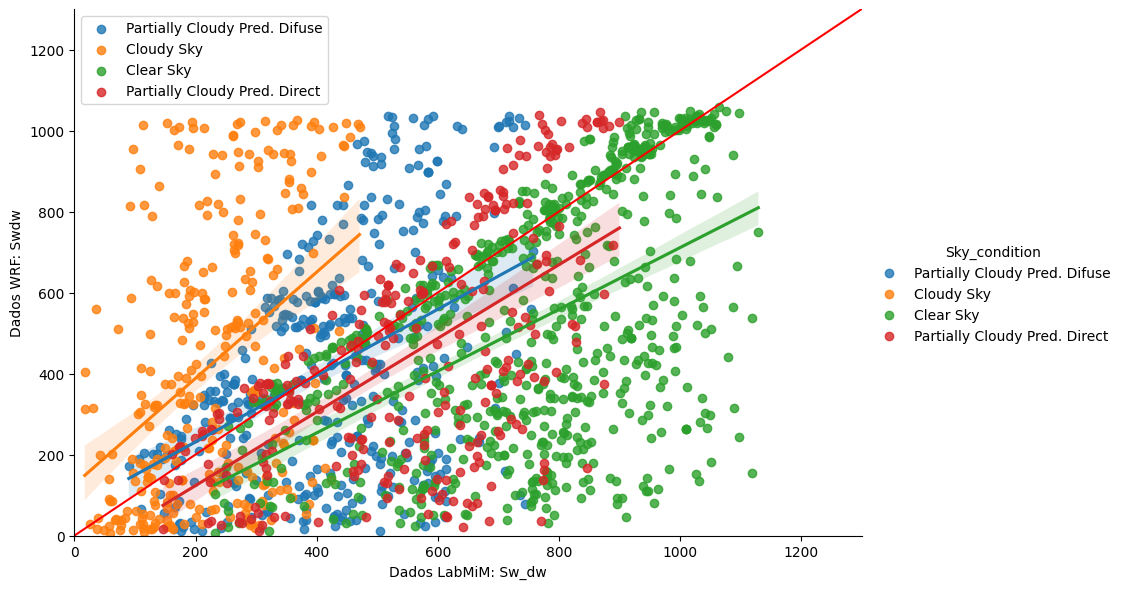

In [21]:
# Sort the merged data frame by the hour_x column


sns.lmplot(x="Sw_dw", y="Swdw", data=merged_hour, hue='Sky_condition', height=6, aspect=1.5);
plt.axline((0, 0), (100, 100), linewidth=1.5, color='r')
plt.xlabel('Dados LabMiM: Sw_dw')
plt.ylabel('Dados WRF: Swdw')
plt.ylim(0,1300)
plt.xlim(0,1300)
plt.legend()
plt.show()

2014, Gueymard
### A review of validation methodologies and statistical performance indicators for modeled solar radiation data: Towards a better bankability of solar projects

- Mean Bias Difference (MBD)

In [ ]:
def mean_bias_error(true, pred):
    true1 = [i**2 for i in true]
    pred1 = [i**2 for i in pred]
    mbe_loss = np.mean(true1 - pred1)
    return mbe_loss

mean_bias_error(merged['Sw_dw'],merged['Swdw'])

67.86975994897959

- Root Mean Square Error

In [ ]:
def rmsd(true, pred):
  MSE = np.square(np.subtract(true,pred)).mean()  
  return math.sqrt(MSE)

print("Root Mean Square Error: {}".format(rmsd(merged['Sw_dw'],merged['Swdw'])))

Root Mean Square Error: 319.1035542287909
